# Generate SWAN bathy from GEBCO

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from pathlib import Path
import intake
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

import rompy
from rompy.swan import SwanModel, SwanGrid
from rompy.filters import crop_filter

xropt = xr.set_options(display_style="html", display_expand_attrs=False)

### Instantiate a model simulation

In [2]:
new_simulation = SwanModel(
    run_id='test_swan',
    template='../rompy/templates/swan',
    output_dir='simulations'
)

Default context: (from cookiecutter.json)
OrderedDict([('run_id', 'run_0001'),
             ('compute_start', '20200221.040000'),
             ('compute_interval', '0.25 HR'),
             ('compute_stop', '20200224.040000'),
             ('out_start', '20200221.040000'),
             ('out_intvl', '1.0 HR'),
             ('output_locs',
              OrderedDict([('coords',
                            [['115.61', '-32.618'],
                             ['115.686067', '-32.532381']])])),
             ('cgrid', 'REG 115.68 -32.76 77 0.39 0.15 389 149'),
             ('cgrid_read', ''),
             ('wind_grid',
              'REG 115.3 -32.8 0.0 2 3 0.3515625 0.234375  NONSTATION '
              '20200221.040000  10800.0 S'),
             ('wind_read', "SERIES 'extracted.wind' 1 FORMAT '(3F8.1)'"),
             ('bottom_grid',
              'REG 115.68 -32.76 77 390 150 0.001 0.001 EXC -99.0'),
             ('bottom_file', 'bathy.bot'),
             ('friction', 'MAD'),
             (

### Parse the parameters of the grid defined in the template and create a SwanGrid object to conveniently get the bounding box

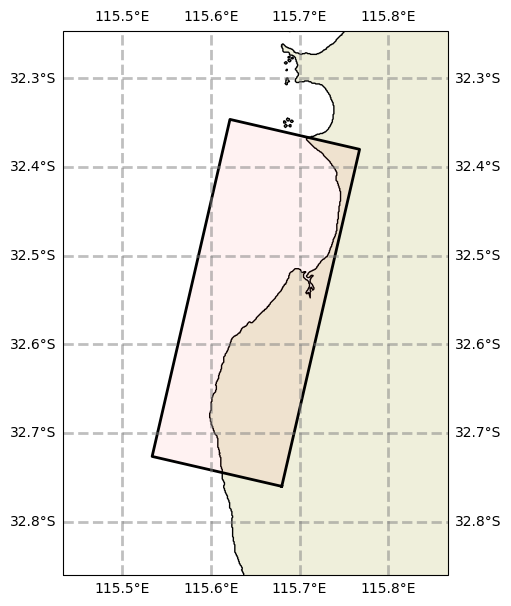

In [3]:
grid = new_simulation.grid

fig, ax = grid.plot()

---
## Generate bathymetry from Gebco

### Load dataset from the catalog

- Choose appropriate xarray_kwargs if reading from custom urlpath / format
- Choose chunks based on the size of the slice to read for performance
- Derived variable filter included in the catalog definition to define `depth`
- Other filters can be defined here using 'transform', or after loading dask

In [7]:
cat = intake.open_catalog("/source/csiro/rompy/rompy/catalogs/master.yaml")

dset = cat.bathy.gebco_2020(
    # urlpath="/static/glob/gebco20/GEBCO_2020_4km.nc", # Replace it by netcdf or zarr urlpath
    xarray_kwargs=dict(chunks={"lat": 128, "lon": 128}),
).to_dask()

dset

<xarray.Dataset>
Dimensions:    (lon: 86400, lat: 43200)
Coordinates:
  * lon        (lon) float64 -180.0 -180.0 -180.0 -180.0 ... 180.0 180.0 180.0
  * lat        (lat) float64 -90.0 -89.99 -89.99 -89.99 ... 89.99 89.99 90.0
Data variables:
    elevation  (lat, lon) int16 dask.array<chunksize=(128, 128), meta=np.ndarray>
    depth      (lat, lon) int16 dask.array<chunksize=(128, 128), meta=np.ndarray>
Attributes: (8)

### Crop dataset based on swan grid bbox

It is not clear where the cropping should happen, in the model wrapper, in the swan accessor, in the catalog call? Here we do it explicitly as in the swan example notebook

In [8]:
min_lon, min_lat, max_lon, max_lat = grid.bbox(buffer=0)
print(f"Swan exact bbox:    ({min_lon:0.4f}, {max_lon:0.4f}), ({min_lat:0.4f}, {max_lat:0.4f})")

min_lon, min_lat, max_lon, max_lat = grid.bbox(buffer=0.05)
print(f"Swan buffered bbox: ({min_lon:0.4f}, {max_lon:0.4f}), ({min_lat:0.4f}, {max_lat:0.4f})")

dset = crop_filter(dset, lat=slice(min_lat, max_lat), lon=slice(min_lon, max_lon))
print(f"Gebco cropped bbox: ({float(dset.lon.min()):0.4f}, {float(dset.lon.max()):0.4f}), ({float(dset.lat.min()):0.4f}, {float(dset.lat.max()):0.4f})")

dset

Swan exact bbox:    (115.5338, 115.7677), (-32.7600, -32.3463)
Swan buffered bbox: (115.4838, 115.8177), (-32.8100, -32.2963)
Gebco cropped bbox: (115.4854, 115.8146), (-32.8062, -32.2979)


<xarray.Dataset>
Dimensions:    (lon: 80, lat: 123)
Coordinates:
  * lon        (lon) float64 115.5 115.5 115.5 115.5 ... 115.8 115.8 115.8 115.8
  * lat        (lat) float64 -32.81 -32.8 -32.8 -32.79 ... -32.31 -32.3 -32.3
Data variables:
    elevation  (lat, lon) int16 dask.array<chunksize=(98, 80), meta=np.ndarray>
    depth      (lat, lon) int16 dask.array<chunksize=(98, 80), meta=np.ndarray>
Attributes: (8)

### Write ASCII and update `bottom_grid` cmd

In [9]:
# Write SWAN ASCII file
bottom_file = Path(new_simulation.staging_dir) / new_simulation.default_context["bottom_file"]
inpgrid, readinp = dset.swan.to_bottom_grid(
    output_file=bottom_file,
    x="lon",
    y="lat",
    z="depth",
    vmin=0.0
)

# Update context
new_simulation.default_context["bottom_grid"] = inpgrid
# new_simulation.settings['bottom_grid'] = readinp # Not a template in the cookiecutter

# Keep a netcdf copy
dset[["depth"]].to_netcdf(bottom_file.with_suffix(".nc"))

new_simulation.default_context["bottom_grid"]

'REG 115.48541666666665 -32.80625 0 79 122 0.004166666666666475 0.004166666666666663 EXC -99.0'

### Plot bathy

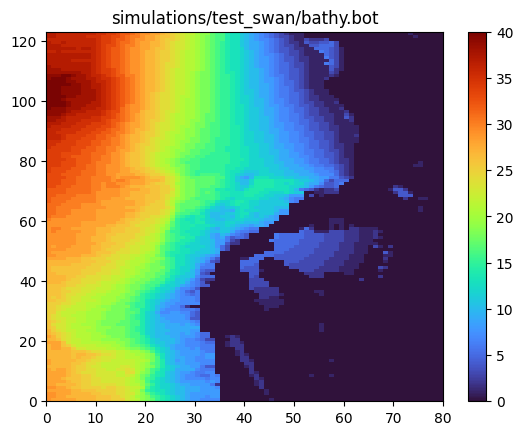

In [12]:
bathy = np.loadtxt(bottom_file)
p = plt.pcolormesh(bathy, cmap="turbo", vmin=0, vmax=40)
cb = plt.colorbar()
t = plt.title(bottom_file)